<a href="https://colab.research.google.com/github/henry-bokyum-kim/NNStudy/blob/bokyum/FastRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# # download the Penn-Fudan dataset
# !wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
# # extract it in the current folder
# !unzip PennFudanPed.zip

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import torchvision.transforms as transforms

import random

norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)
trans = transforms.Compose([
    transforms.Resize((800,800)),
    transforms.ToTensor(),
])

dataset = torchvision.datasets.ImageFolder('./PennFudanPed', transform=trans)

dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=1,
                                         shuffle=False)

In [0]:
import os

#get shapes
image_list = os.listdir('./PennFudanPed/PNGImages/')
image_list.sort()
image_list

from PIL import Image
file_path = './PennFudanPed/PNGImages/'

shapes = []
for i in image_list:
    shapes.append(np.array(Image.open(file_path + i)).shape[:-1])

In [0]:
#get boxes
import json
import re

p = re.compile('.*(object [0-9]).* : (.*)')

file_path = './PennFudanPed/Annotation/'

anno_list = os.listdir('./PennFudanPed/Annotation/')
anno_list.sort()
anno_list

annotation = []
for i in anno_list:
    txt = open(file_path + i, 'r')
    anno = {}
    for l in txt.readlines():
        match = p.match(l)
        if match:
            key, value = match.groups()
            if key not in anno:
                anno[key] = []
            anno[key].append(value)
    annotation.append(anno)

an = [[list(map(lambda x:json.loads(x), row[key][1].replace('(', '[').replace(')',']').split(' - '))) for key in row] for row in annotation]

In [0]:
#caculate reshaped box boundaries
resized_boxes = []
for shape, boxes in zip(shapes, an):
    h_ratio = 800/shape[0]
    w_ratio = 800/shape[1]
    
    resized = []
    for box in boxes:
        x0 = round(box[0][0] * w_ratio)
        y0 = round(box[0][1] * h_ratio)
        x1 = round(box[1][0] * w_ratio)
        y1 = round(box[1][1] * h_ratio)
        
        resized.append([(x0,y0), (x1,y1)])
        
    resized_boxes.append(resized)

In [0]:
def draw_boxes(ax, boxes, color='r'):
    for box in boxes:
        rect = patches.Rectangle((box[0][0], box[0][1]), box[1][0]-box[0][0], box[1][1]-box[0][1], linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

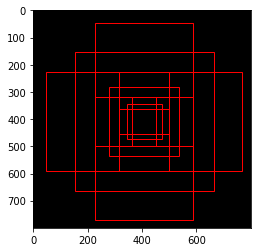

In [6]:
import torch
width = 800
heigth = 800
subsample = 16
image = torch.zeros((1, 3, width, heigth)).float()

w_cntrs = list(range(int(subsample/2), width, subsample))
h_cntrs = list(range(int(subsample/2), heigth, subsample))

import math

def get_anchor(w_, h_, subsample, ratio=(0.5,1,2), size=None):
    if size == None:
        size = (int(subsample/2), subsample, subsample*2)
        
    anchors = []
    for r_ in ratio:
        anchor_ratio = np.array((math.sqrt(r_), math.sqrt(1/r_)))
        for s_ in size:
            anchor_shape = anchor_ratio * s_ * subsample
            x0 = round(w_ - anchor_shape[0]/2)
            x1 = round(w_ + anchor_shape[0]/2)
            y0 = round(h_ - anchor_shape[1]/2)
            y1 = round(h_ + anchor_shape[1]/2)
            
            anchors.append([(x0,y0),(x1,y1)])
    return np.array(anchors)

anchor = get_anchor(w_cntrs[25], h_cntrs[25], subsample)

fig, ax = plt.subplots(1)

ax.imshow(image.squeeze().permute(1,2,0))
draw_boxes(ax, anchor)

In [0]:
# generate anchors
anchors = []
for y in range(int(subsample/2),800,subsample):
    for x in range(int(subsample/2),800,subsample):
        anchor = get_anchor(x,y,subsample)
        anchors.extend(anchor)
anchors = np.array(anchors)

index_inside = np.where(
        (anchors[:,0,0] >= 0) &
        (anchors[:,0,1] >= 0) &
        (anchors[:,1,0] <= 800) &
        (anchors[:,1,1] <= 800)
    )[0]

anchors_inside = anchors[index_inside]

In [0]:
#calculate iou and make labelset

def get_iou(b1, b2):
    a1 = (b1[1][0] - b1[0][0]) * (b1[1][1] - b1[0][1])
    a2 = (b2[1][0] - b2[0][0]) * (b2[1][1] - b2[0][1])
    ai = max(0,(min(b1[1][0], b2[1][0]) - max(b1[0][0], b2[0][0]))) \
    * max(0,(min(b1[1][1], b2[1][1]) - max(b1[0][1], b2[0][1])))
    
    au = a1 + a2 - ai
    return ai/au

labels = []
norm_locs = []
for i, target in enumerate(resized_boxes):
    pos_indices = False
    neg_indices = True
    ious = []
    for target_box in target:
        iou_list = []
        for inside in anchors_inside:
            iou = get_iou(inside,target_box)
            iou_list.append(iou)
        iou_list = np.array(iou_list)

        pos = iou_list > 0.7
        if pos.sum() < 1:
            pos[iou_list.argmax()] = 1

        neg = iou_list < 0.3
        pos_indices = pos_indices + pos
        neg_indices = neg_indices * neg
        ious.append(iou_list)

    label = -np.ones(len(anchors_inside))
    label[neg_indices] = 0
    label[pos_indices] = 1
    
    final_label = -np.ones(len(anchors))
    final_label[index_inside] = np.array(label)
    
    labels.append(final_label)
    
    ious = np.array(ious)
    max_iou_box = np.array([target[i] for i in ious.argmax(0)])
    
    height = anchors_inside[:,1,0] - anchors_inside[:,0,0]
    width = anchors_inside[:,1,1] - anchors_inside[:,0,1]
    x_ctr = anchors_inside[:,0,0] + 0.5 * heigth
    y_ctr = anchors_inside[:,0,1] + 0.5 * width
    
    max_iou_height = max_iou_box[:,1,0] - max_iou_box[:,0,0]
    max_iou_width = max_iou_box[:,1,1] - max_iou_box[:,0,1]
    max_iou_x_ctr = max_iou_box[:,0,0] + 0.5 * max_iou_height
    max_iou_y_ctr = max_iou_box[:,0,1] + 0.5 * max_iou_width
    
    eps = np.finfo(height.dtype).eps
    height = np.maximum(height, eps)
    width = np.maximum(width, eps)
    
    dx = (max_iou_x_ctr - x_ctr) / height
    dy = (max_iou_y_ctr - y_ctr) / width
    dh = np.log(max_iou_height/height)
    dw = np.log(max_iou_width/width)
    
    anchor_locs = np.vstack((dx, dy, dh, dw)).transpose()
    final_locs = np.zeros((len(anchors), 4))
    final_locs[index_inside] = anchor_locs
    norm_locs.append(final_locs)
    
labels = np.array(labels)
norm_locs = np.array(norm_locs)

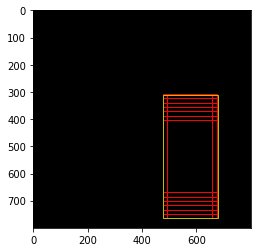

In [9]:
height = anchors[:,1,0] - anchors[:,0,0]
width = anchors[:,1,1] - anchors[:,0,1]
x_ctr = anchors[:,0,0] + 0.5 * heigth
y_ctr = anchors[:,0,1] + 0.5 * width

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

idx = 12
fig, ax = plt.subplots(1)
ax.imshow(image.squeeze().permute(1,2,0))
draw_boxes(ax, [anchors[i] for i in np.where(labels[idx] == 1)[0]])
draw_boxes(ax, resized_boxes[idx], 'y')

In [0]:
cnn = torchvision.models.vgg16().features[:29]

class RPN(nn.Module):
    def __init__(self, k):
        super(RPN, self).__init__()
        self.k = k
        self.inter = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.ReLU()
        )
        self.cls = nn.Conv2d(512, 18, 1, 1)
        self.reg = nn.Conv2d(512, 36, 1, 1)
        
    def forward(self, x):
        x = self.inter(x)
        return self.cls(x), self.reg(x)

class FasterRCNN(nn.Module):
    def __init__(self, cnn, k):
        super(FasterRCNN, self).__init__()
        self.k = k
        self.cnn = cnn
        self.rpn = RPN(self.k)
        cnn.eval()
    
    def forward(self, x):
        feature_map = self.cnn(x)
        cls, reg = self.rpn(feature_map)
        
        return cls, reg

device = "cuda:0" if torch.cuda.is_available() else "cpu"
net = FasterRCNN(cnn, 9).to(device)
LR = 0.001
EPOCH = 10
opt = optim.Adam(net.parameters(), lr = LR)
nll = nn.CrossEntropyLoss()
mse = nn.MSELoss(reduction=None)
gamma = 0.1

In [0]:
image = []
for i, (im, lb) in enumerate(dataloader):
    if lb != 1:
        continue
    image.append(im)

In [12]:
for epoch in range(EPOCH):
    for idx in range(len(image)):
        pos = np.where(labels[idx] == 1)[0]
        neg = random.sample(list(np.where(labels[idx] == 0)[0]), 128-len(pos))

        y = np.zeros(128)
        y[:len(pos)] = 1
        y = torch.LongTensor(y).to(device)

        y_box = torch.FloatTensor(np.concatenate([norm_locs[idx][pos], norm_locs[idx][neg]])).to(device)

        opt.zero_grad()
        cls, reg = net(image[idx].to(device))

        pred = cls.permute(0,2,3,1).reshape(-1,2).contiguous()
        pred_box = reg.permute(0,2,3,1).reshape(-1,4).contiguous()

        pred_selected = torch.cat([pred[pos], pred[neg]], 0)
        pred_box_selected = torch.cat([pred_box[pos], pred_box[neg]], 0)

        nll_loss = nll(pred_selected, y)
        mse_loss = (y*(((pred_box_selected - y_box)**2).sum(1)**1/2)).sum()

        loss = nll_loss/128 + gamma * mse_loss / 128
        loss.backward()
        print("[%2d -%3d]"%(epoch, idx), nll_loss.item(), mse_loss.item(), loss.item())
        opt.step()

[ 0 -  0] 0.6949360966682434 34.98394012451172 0.032760392874479294
[ 0 -  1] 1.1702473163604736 1060.4571533203125 0.837624728679657
[ 0 -  2] 0.6510669589042664 0.24746808409690857 0.00527979526668787
[ 0 -  3] 0.6013869047164917 7.414887428283691 0.01049121655523777
[ 0 -  4] 0.2550177276134491 6.784130573272705 0.007292428053915501
[ 0 -  5] 0.1693919152021408 11.933708190917969 0.010646583512425423
[ 0 -  6] 0.45653781294822693 10.065691947937012 0.011430524289608002
[ 0 -  7] 0.4776548743247986 27.00424575805664 0.024828746914863586
[ 0 -  8] 0.476611852645874 2.848444938659668 0.005948877893388271
[ 0 -  9] 0.5080771446228027 0.3163371980190277 0.004216491244733334
[ 0 - 10] 0.5033324956893921 0.3331789970397949 0.00419258140027523
[ 0 - 11] 0.4843122065067291 2.422578811645508 0.005676328670233488
[ 0 - 12] 0.5047418475151062 29.824560165405273 0.027243733406066895
[ 0 - 13] 0.506199836730957 0.29331180453300476 0.004183836281299591
[ 0 - 14] 0.5632909536361694 6.05451679229736

In [37]:
net.eval()

cls, reg = net(image[0].to(device))

net.train()

FasterRCNN(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [0]:
score = cls.data.cpu().permute(0,2,3,1).reshape(-1, 2)[:,1]
top20_idx = score.topk(20)

In [0]:
roi_box = reg.cpu().permute(0,2,3,1).reshape(-1,4).data.numpy()
dx, dy, dh, dw = roi_box[:,0::4].reshape(-1), roi_box[:,1::4].reshape(-1), roi_box[:,2::4].reshape(-1), roi_box[:,3::4].reshape(-1)
del roi_box

In [0]:
x, y= dx*height + x_ctr, dy*width + y_ctr
del dx, dy
x, y = x[top20_idx[1]], y[top20_idx[1]]

In [0]:
h, w = np.exp(dh)*height, np.exp(dw)*width
del dh, dw
h, w = h[top20_idx[1]], w[top20_idx[1]]

In [0]:
roi = np.zeros((len(x),2,2))

roi[:,0,0] = x-0.5*h
roi[:,1,0] = x+0.5*h
roi[:,0,1] = y-0.5*w
roi[:,1,1] = y+0.5*w

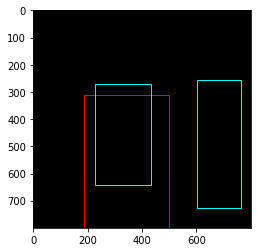

In [56]:
fig, ax = plt.subplots(1)
ax.imshow(np.zeros((800,800,3),dtype=np.uint8))
draw_boxes(ax, roi[4:5])
draw_boxes(ax, resized_boxes[0], '#00ffff')